# Analysis

**Hypothesis**: Epithelial cells in lung adenocarcinoma exhibit distinct functional states that correlate with smoking history, disease stage, and Treg abundance in the tumor microenvironment.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/data/luyit/script/git/LabAcceleration/data_match/data/ad4aac9c-28e6-4a1f-ab48-c4ae7154c0cb.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Epithelial cells in lung adenocarcinoma exhibit distinct functional states that correlate with smoking history, disease stage, and Treg abundance in the tumor microenvironment.

## Steps:
- Subset the anndata object to focus on epithelial cells only
- Perform higher-resolution clustering of epithelial cells to identify novel subpopulations with dynamic resolution
- Identify marker genes for each epithelial subpopulation and functionally annotate them
- Compare epithelial subpopulation proportions across smoking status categories using chi-square tests
- Calculate Spearman correlations between epithelial subpopulation abundances and disease stage/treatment status
- Use linear mixed models to compute the association between epithelial state abundances and Treg fractions across samples, accounting for patient-level covariates
- Visualize epithelial state-specific gene expression gradients along disease progression axes using PAGA trajectory analysis


## This code subsets epithelial cells, performs preprocessing (normalization, log transformation, HVG selection, batch correction, and scaling), then conducts PCA and dynamic clustering (Leiden algorithm). Finally, it visualizes subclusters and mitochondrial QC metrics.

normalizing counts per cell


    finished (0:00:02)


extracting highly variable genes


    finished (0:00:01)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Standardizing Data across genes.



Found 25 batches



Found 0 numerical variables:


Fitting L/S model and finding priors



Finding parametric adjustments



Adjusting data



computing PCA


    with n_comps=30


    finished (0:00:05)


computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)


running Leiden clustering


    finished: found 40 clusters and added
    'epithelial_subcluster', the cluster labels (adata.obs, categorical) (0:00:24)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)


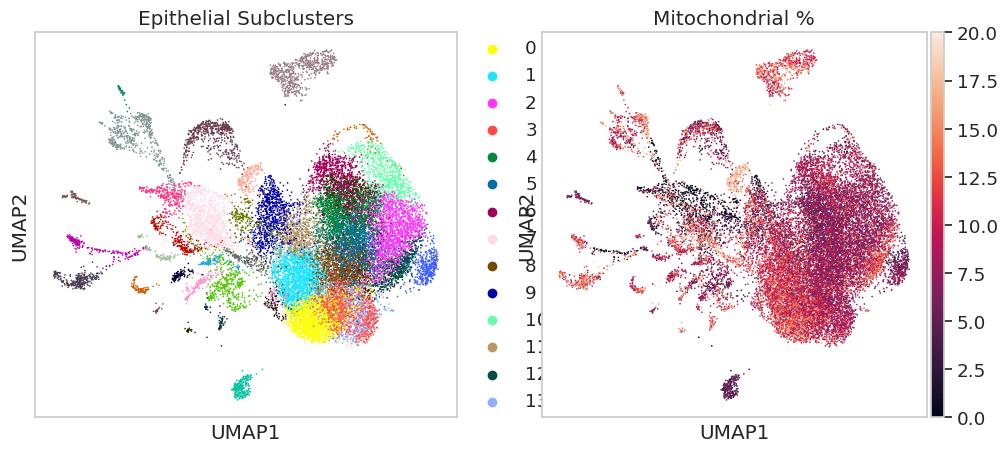

Cluster distribution:
epithelial_subcluster
0     1761
1     1745
2     1554
3     1392
4     1208
5     1125
6     1087
7      915
8      855
9      830
10     707
11     704
12     695
13     694
14     640
15     545
16     508
17     498
18     491
19     446
20     413
21     276
22     273
23     259
24     247
25     235
26     221
27     218
28     216
29     215
30     180
31     109
32     108
33      99
34      97
35      96
36      80
37      53
38      38
39      22
Name: count, dtype: int64

Median MT%:
epithelial_subcluster
0      9.297297
1      8.959276
2      6.545637
3      7.154897
4      5.523875
5      6.499430
6      7.761733
7      4.981320
8      6.349207
9      7.015515
10     6.894956
11     7.905852
12     9.861933
13     7.259317
14    11.296640
15     6.277422
16    10.203482
17     7.015310
18     5.909091
19     6.181954
20     5.519481
21    12.500450
22     1.975477
23    11.559162
24     9.621353
25     1.166058
26     4.000000
27    15.755783
28     

In [2]:


import scanpy as sc
import pandas as pd
import numpy as np

# Subset to epithelial cells
epithelial_adata = adata[adata.obs['cell_type'] == 'epithelial cell'].copy()

# Preprocessing steps
sc.pp.normalize_total(epithelial_adata, target_sum=1e4)
sc.pp.log1p(epithelial_adata)
sc.pp.highly_variable_genes(epithelial_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
epithelial_adata = epithelial_adata[:, epithelial_adata.var.highly_variable]  # Subset to HVGs

# Batch correction
if 'sample_name' in epithelial_adata.obs.columns:
    sc.pp.combat(epithelial_adata, key='sample_name')
sc.pp.scale(epithelial_adata)
sc.pp.pca(epithelial_adata, n_comps=30, random_state=42)
sc.pp.neighbors(epithelial_adata, n_neighbors=15, n_pcs=30, method='umap')

# Dynamic clustering resolution
target_clusters = min(20, max(5, epithelial_adata.n_obs // 200))
sc.tl.leiden(epithelial_adata, resolution=target_clusters/10, random_state=42, key_added='epithelial_subcluster')

# Visualize clusters and QC
sc.tl.umap(epithelial_adata, random_state=42)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(epithelial_adata, color='epithelial_subcluster', ax=axs[0], show=False, title='Epithelial Subclusters')
sc.pl.umap(epithelial_adata, color='pct_counts_mt', ax=axs[1], show=False, title='Mitochondrial %')
plt.show()

# Print cluster statistics
cluster_counts = epithelial_adata.obs['epithelial_subcluster'].value_counts()
mt_medians = epithelial_adata.obs.groupby('epithelial_subcluster')['pct_counts_mt'].median()
print(f"Cluster distribution:\n{cluster_counts}\n")
print(f"Median MT%:\n{mt_medians}")
